In [63]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import os

%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import rcParams
rcParams['font.family'] = 'monospace'
#rcParams['font.sans-serif'] = ['Tahoma']

from glob import glob
import math
import time
import k2flix

#-----------------------------------10-------------------------------------

def display_overlay(oid_list,location, start, stop):

    os.chdir(location)
    all_flux={}
    fig = plt.figure()
    ax = fig.add_subplot(111)
    for idx, oid in enumerate(oid_list):
        flux = pd.read_csv(str(oid)+'_flux.csv',
                          usecols = ['flux_gap','time'])
        s = start
        t = stop
        mean = flux.flux_gap.median()
        plt.plot(list(flux.time)[s:t],list(flux.flux_gap/mean)[s:t],label='EPIC {}'.format(oid))
    #plt.savefig('/home/ekaterina/Documents/appaloosa/stars_shortlist/share/{}_{}_{}.jpg'.format(test,start,stop))
    plt.show()
    return
    
def edges_to_bool(start_stop):
    
    if start_stop.empty:
        return [0]
    else:
        rangeflare = []
        for i,row in start_stop.iterrows():
                rangeflare.append(list(range(int(row.istart),int(row.istop))))
        isflare = np.zeros(start_stop.istop.iloc[-1]+1)
        rangeflare = [item for sublist in rangeflare for item in sublist]

        np.put(isflare,rangeflare,np.ones_like(rangeflare))
        return isflare

def create_inflated_binoms(oid_list,p,maxlen,display=False):

    inflated_binoms={}
    for i in [1,3,5]:
        binom = 0
        for oid in oid_list:
            not_inflated = np.random.binomial(1,p[oid]/i,maxlen//i)
            inflated = [item for sublist in [[j]*i for j in not_inflated] for item in sublist]
            binom = np.add(inflated,binom)
        inflated_binoms[i]=binom
    if display == True:
        plt.plot(inflated_binoms[3])
    
    return inflated_binoms

def remove_systematics(seq,maxlen,maxpoints=5):
    
    #create cleaned data frame:
    systematics = list(seq[maxpoints<seq.sum(axis=1)].index)
    remove = sorted(list(set([item for sublist in [[i-1,i,i+1] for i in systematics] for item in sublist])))
    seq_drop = seq.drop(labels=remove)
    
    #overlap dirty, overlap clean:
    od = [seq[seq.sum(axis=1)>=i].shape[0] for i in range(21)]
    oc = [seq_drop[seq_drop.sum(axis=1)>=i].shape[0] for i in range(21)]

    #Calculate the binomial probability for cleaned version
    p = seq.sum()/maxlen
    return od, oc, p, remove

def display_comparison(inflated_binoms, overlap_dirty,overlap_clean, test):
    fig = plt.figure(figsize=(8,6))
    ax = fig.add_subplot(111)
    for i,binom in inflated_binoms.items():
        overlap_binom, edges = np.histogram(binom, bins=21, range=(0,21))
        #print(overlap_binom)
        overlap_binom = np.cumsum(overlap_binom[::-1])[::-1]
        #print(overlap_binom,'\n',overlap)
        ax.plot(overlap_binom,label='{}-times inflated binomial distribution'.format(i))
    ax.plot(overlap_dirty,label='Real distribution with systematic errors')
    ax.plot(overlap_clean,label='Real distribution - systematics removed')
   
    #ax.plot(np.array(overlap)-overlap_binom,label='real-random')
    ax.legend(bbox_to_anchor=(1, 1), loc=1, borderaxespad=1.)
    ax.set_yscale('log')
    #plt.xlim(0,5)
    print(os.getcwd())
    plt.savefig('stars_shortlist/share/{}_sys_cuts.jpg'.format(test))
    fig.show()
    return

def generate_sequence(oid_list,location):

    #os.chdir(location)

    all_isflare = {}
    for oid in oid_list:

        start_stop = pd.read_csv('{}/{}_flares.csv'.format(location,oid))
        all_isflare[oid] = edges_to_bool(start_stop)

    maxlen = max([len(val) for key,val in all_isflare.items()])

    for key, val in all_isflare.items():
        all_isflare[key] = np.concatenate((val,np.zeros(maxlen-len(val))))
        #print(len(val))
    seq = pd.DataFrame(all_isflare)
    return maxlen, seq

def systematic_set(remove):
    
    s=[]
    j = 0
    for i, item in enumerate(remove[:-1]):
            if item+1 != remove[i+1]:
                s.append(remove[j:i+1])
                j = i+1 
    return s

def systematics_wrap(location, oid_list, test, display=False):
    maxlen, seq = generate_sequence(oid_list, location)
    overlap_dirty, overlap_clean, p, remove = remove_systematics(seq,maxlen)
    sys_set = pd.Series([i for item in systematic_set(remove) for i in item])
    inflated_binoms = create_inflated_binoms(oid_list, p, maxlen,display=display)
    sys_set.to_csv('stars_shortlist/{0}/results/{1}/{0}_systematics.csv'.format(cluster,test))
    if display == True:
        display_comparison(inflated_binoms, overlap_dirty, overlap_clean)
        #FCOR
        display_overlay(oid_list,location, 1330, 1360)
        #FLUX
        display_overlay(oid_list, location, 1310, 1330)
    return sys_set, overlap_dirty


#----------------------------------11-------------------------------------


def find_nearest(array,value):

    idx = np.searchsorted(array, value, side="left")
    if idx > 0 and (idx == len(array) or math.fabs(value - array[idx-1]) < math.fabs(value - array[idx])):
        return array[idx-1], idx-1
    else:
        return array[idx], idx


def tpf_time_match(flux, tpf):

    flags = []
    timed = []
    quality = tpf.hdulist[1].data['QUALITY']
    print(time.clock())
    for id_,row in flux.iterrows():

        t, idx_ = find_nearest(tpf.bkjd(), row.time)
        timed.append(t)
        flags.append(quality[idx_])

    flux['tpf_flags'] = flags
    flux['tpf_time'] = timed
    return flux



def wrap_tpf_time_match(oid_list,test,C):
    tpfs, flux, flares = dict(), dict(), dict()
    for oid in oid_list:
        tpfs[oid] = k2flix.TargetPixelFile('ktwo{}-c{}_lpd-targ.fits.gz'.format(oid,C))
        
        flares[oid] = pd.read_csv('results/{}/{}_flares.csv'.format(test,oid))
        if glob('results/{}/{}_tpf_times_FLUX.csv'.format(test,oid)) == []:
            flux[oid] = pd.read_csv('results/{}/{}_flux.csv'.format(test,oid),usecols=['flux_gap','time','flux_model'])
            flux[oid] = tpf_time_match(flux[oid],tpfs[oid])
            flux[oid].to_csv('results/{}/{}_tpf_times_FLUX.csv'.format(test,oid))
        else:
            flux[oid] = pd.read_csv('results/{}/{}_tpf_times_FLUX.csv'.format(test,oid),
                                usecols=['flux_gap','time','flux_model','tpf_time','tpf_flags'])
    return flux, flares, tpfs
                                          
def edges_to_bool2(start_stop,flux):
    
    rangeflare = []
    for i,row in start_stop.iterrows():
            rangeflare.append(list(range(int(row.istart),int(row.istop+1))))
    isflare = np.zeros_like(flux.time.tolist())
    rangeflare = [item for sublist in rangeflare for item in sublist]

    np.put(isflare,rangeflare,np.ones_like(rangeflare))

    return isflare  

def bool_to_edges(isflare):
    
    c, start, stop = False, [], []
    isflare = list(isflare)
    for id_, bool_ in enumerate(isflare):
        if c == False and bool_ == True:
            start.append(id_)
            c = True
        elif c == True and bool_ == False:
            stop.append(id_-1)
            c = False
    start_stop = pd.DataFrame({'istart':start},dtype=int)#,'istop':stop})
    start_stop = start_stop.join(pd.Series(stop,name='istop',dtype=int))
    return start_stop   

def remove_thruster_firings(tpfs, flux, flares, oid):
    remove = []
    for i in range(len(tpfs[oid].hdulist[1].data['FLUX'])): 
        if tpfs[oid].hdulist[1].data['QUALITY'][i] > 524288:#flag values are summed up!
            remove.append(tpfs[oid].bkjd(i))
            try:
                remove.append(tpfs[oid].bkjd(i-1))
            except IndexError:
                print('IndexError -1')
                pass
            try:
                remove.append(tpfs[oid].bkjd(i+1))
            except IndexError:
                print('IndexError +1')
                pass
    remove_id = []
    for rt in sorted(list(set(remove))):
        rem_id = flux[oid].index.values[np.round(flux[oid].time,6) == np.round(rt,6)]
        if rem_id != []:
            remove_i.append(rem_id)
    isflare = edges_to_bool2(flares[oid],flux[oid])
    new_isflare = np.array(isflare)
    new_flags = np.array(flux[oid].tpf_flags)
    for id_ in remove_id:
        if isflare[id_] == 1.:
            for j, row in flares[oid].iterrows():
                if (row.istart <= id_) & (row.istop+1 >=id_):
                    new_isflare[row.istart:row.istop+1] = 0
                    new_flags[row.istart:row.istop+1] = 0

    flux[oid]['isflare'] = isflare
    flux[oid]['new_isflare'] = new_isflare
    flux[oid]['new_tpf_flags'] = new_flags
    return


def remove_systematics2(flux,test,cluster,oid):
    print(os.getcwd())
    s = pd.read_csv('results/{}/{}_systematics.csv'.format(test,cluster),names=['systematics']).systematics.tolist()
    flux[oid]['tpf_flags_wo_systematics'] = np.array(flux[oid].tpf_flags)
    flux[oid]['isflare_wo_systematics'] = np.array(flux[oid]['isflare'])
    flux[oid]['tpf_flags_wo_systematics'].iloc[s]= 0
    flux[oid]['isflare_wo_systematics'].iloc[s]= 0
    return

def flag_df(flux):
    index = [1,8192,524288]
    columns = ['>',
               '>_after_thruster_removal',
               '>_after_systematics_removal',
               '>_left_overall',
               '>_coinciding_with_flare_candidates',
               '>_coinciding_with_clean_flare_candidates',
              ]
    flags = pd.DataFrame(index=index, columns=columns)
    for flag in index:
        flags[columns[0]].loc[flag] = flux[flux.tpf_flags >= flag].shape[0]
        flags[columns[1]].loc[flag] = flux[flux.new_tpf_flags >= flag].shape[0]
        flags[columns[2]].loc[flag] = flux[flux.tpf_flags_wo_systematics >= flag].shape[0]
        flags[columns[3]].loc[flag] = flux[(flux.tpf_flags_wo_systematics >= flag) & (flux.new_tpf_flags >= flag)].shape[0]
        flags[columns[4]].loc[flag] = flux[(flux.isflare == True) & (flux.tpf_flags >= flag)].shape[0]
        flags[columns[5]].loc[flag] = flux[(flux.isflare_no_sys_no_thruster == True) & (flux.tpf_flags >= flag)].shape[0]
    return flags.T


In [64]:
cluster = 'NGC_1647'
C = '13'
test = 'run_01'
#---------------------------
#o = 211412571 #M67
#o = 211954033 #M44
o = 247111108 #NGC_1647
#------------------------
os.chdir('/home/ekaterina/Documents/appaloosa')
print(os.getcwd())
params = pd.read_csv('stars_shortlist/{0}/{0}_parameter.csv'.format(cluster))
oid_list = params.EPIC.tolist()

/home/ekaterina/Documents/appaloosa


In [65]:
location = 'stars_shortlist/{}/results/{}'.format(cluster,test)
maxlen, seq = generate_sequence(oid_list, location)
#print(seq.head())

In [66]:
overlap_dirty, overlap_clean, p, remove = remove_systematics(seq,maxlen,maxpoints=6)

### Introduce a binomial distribution for comparison, also some where flare time point occur in clusters of 3 or 5 time points

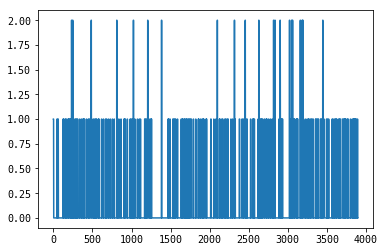

In [67]:
inflated_binoms = create_inflated_binoms(oid_list, p, maxlen,display=True)

### Now compare the cleaned version with the uncleaned one and also the (inflated) binomials:

/home/ekaterina/Documents/appaloosa


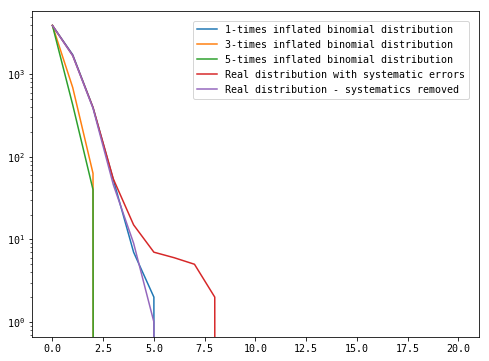

In [68]:
display_comparison(inflated_binoms, overlap_dirty, overlap_clean, test)

In [69]:
loc = 'stars_shortlist/{}/results/{}'.format(cluster,test)
sys, overlap = systematics_wrap(loc, oid_list, test, display=False)

## Match target pixel files with light curve time series

In [70]:
os.chdir('/home/ekaterina/Documents/appaloosa/stars_shortlist/{}'.format(cluster))
flux, flares, tpfs = wrap_tpf_time_match(oid_list, test, C)

In [71]:
for oid in oid_list:
    
    remove_thruster_firings(tpfs, flux, flares, oid)
    remove_systematics2(flux, test, cluster, oid)
    
    flux[oid]['isflare_no_sys_no_thruster'] = (flux[oid].new_isflare == 1.) & (flux[oid].isflare_wo_systematics == 1.)
    
    start_stop = bool_to_edges(flux[oid].isflare_no_sys_no_thruster)
    flares[oid] = flares[oid].join(start_stop,rsuffix='_no_sys_no_thruster')
    
    flux[oid].to_csv('results/{}/{}_tpf_times_FLUX.csv'.format(test,oid))
    flares[oid].to_csv('results/{}/{}_flares.csv'.format(test,oid))
    flux[oid].to_csv('results/{}/{}_flux.csv'.format(test,oid))

/home/ekaterina/Documents/appaloosa/stars_shortlist/NGC_1647
/home/ekaterina/Documents/appaloosa/stars_shortlist/NGC_1647
/home/ekaterina/Documents/appaloosa/stars_shortlist/NGC_1647
/home/ekaterina/Documents/appaloosa/stars_shortlist/NGC_1647
/home/ekaterina/Documents/appaloosa/stars_shortlist/NGC_1647
/home/ekaterina/Documents/appaloosa/stars_shortlist/NGC_1647
/home/ekaterina/Documents/appaloosa/stars_shortlist/NGC_1647
/home/ekaterina/Documents/appaloosa/stars_shortlist/NGC_1647
/home/ekaterina/Documents/appaloosa/stars_shortlist/NGC_1647
/home/ekaterina/Documents/appaloosa/stars_shortlist/NGC_1647
/home/ekaterina/Documents/appaloosa/stars_shortlist/NGC_1647
/home/ekaterina/Documents/appaloosa/stars_shortlist/NGC_1647
/home/ekaterina/Documents/appaloosa/stars_shortlist/NGC_1647
/home/ekaterina/Documents/appaloosa/stars_shortlist/NGC_1647
/home/ekaterina/Documents/appaloosa/stars_shortlist/NGC_1647
/home/ekaterina/Documents/appaloosa/stars_shortlist/NGC_1647
/home/ekaterina/Document